In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

In [2]:
# saved files testing
from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *

modified_pcap_path = "../data/interim/testing_small_perturbed.pcapng"
pcap_file_path = '../data/raw/testing_small.pcapng'

truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
truncated_packets = assign_flow_ids_to_packets(truncated_packets)
print(calculate_delta_time_statistics(7, truncated_packets, direction=0))
#modify_and_write_packets_one_by_one(pcap_file_path, modified_pcap_path, truncated_packets)

{'mean': 0.053693467592592595, 'min': 1e-06, 'max': 1.95455, 'std': 0.1967639528377633}


## timing perturbations

In [3]:
import numpy as np
from scipy.stats import norm

def generate_weights(length, mean, stddev):
    """
    Generates weights for adjusting deltas based on a normal distribution with specified mean and stddev.
    """
    x = np.linspace(0, length, num=length)
    weights = norm.pdf(x, loc=mean, scale=stddev)
    weights /= np.max(weights)  # Normalize
    return weights

def rebuild_timestamps(flow_packets, adjusted_deltas):
    """
    Rebuilds timestamps from adjusted deltas for a sequence of packets.
    """
    timestamp = flow_packets[0].timestamp
    for i, delta in enumerate(adjusted_deltas):
        timestamp += delta
        if i + 1 < len(flow_packets):
            flow_packets[i + 1].timestamp = timestamp

def apply_uniform_perturbation(truncated_packets, flow_id, scaling_factor=1.0):
    """
    Uniformly adjusts timestamps within a specified flow_id, ensuring no adjusted delta exceeds 239.
    """
    flow_packets = sorted([p for p in truncated_packets if p.flow_id == flow_id], key=lambda p: p.timestamp)
    if not flow_packets:
        return truncated_packets

    # Calculate and adjust deltas
    deltas = np.diff([p.timestamp for p in flow_packets])
    adjusted_deltas = np.minimum(deltas * scaling_factor, 239)

    # Rebuild timestamps from adjusted deltas
    rebuild_timestamps(flow_packets, adjusted_deltas)
    return truncated_packets

def apply_normal_perturbation(truncated_packets, flow_id, mean, stddev):
    """
    Adjusts timestamps within a specified flow_id based on a normal distribution with specified mean and stddev,
    ensuring no adjusted delta exceeds 239.
    """
    flow_packets = sorted([p for p in truncated_packets if p.flow_id == flow_id], key=lambda p: p.timestamp)
    if not flow_packets:
        return truncated_packets

    deltas = np.diff([p.timestamp for p in flow_packets])
    weights = generate_weights(len(deltas), mean, stddev)
    adjusted_deltas = np.minimum(deltas * weights, 239)

    # Rebuild timestamps from adjusted deltas
    rebuild_timestamps(flow_packets, adjusted_deltas)
    return truncated_packets

def apply_perturbation(truncated_packets, flow_id, method='uniform', **kwargs):
    """
    Applies a specified perturbation method to packets within a specified flow_id.
    """
    if method == 'uniform':
        return apply_uniform_perturbation(truncated_packets, flow_id, **kwargs)
    elif method == 'normal':
        return apply_normal_perturbation(truncated_packets, flow_id, **kwargs)
    else:
        raise ValueError("Unsupported perturbation method.")


In [4]:
def apply_perturbation(truncated_packets, flow_id, method='uniform', scaling_factor=1.0, mean=None, stddev=None):
    """
    Applies a specified perturbation method to packets within a specified flow_id. Chooses the perturbation method
    based on input parameters and applies it to the packet timestamps.
    
    Parameters:
    - truncated_packets: A list of TruncatedPacket objects to be adjusted.
    - flow_id: The specific flow_id for which the perturbation is applied.
    - method: Type of perturbation ('uniform', 'normal').
    - scaling_factor: Scaling factor for the perturbation; used for 'uniform' method.
    - mean: The mean location for 'normal' perturbation method.
    - stddev: The standard deviation for 'normal' perturbation method.
    """
    if method == 'uniform':
        # Apply uniform perturbation
        return apply_uniform_perturbation(truncated_packets, flow_id, scaling_factor)
    elif method == 'normal':
        # Validate mean and stddev for normal perturbation
        if mean is None or stddev is None:
            raise ValueError("Mean and stddev must be provided for normal perturbation.")
        return apply_normal_perturbation(truncated_packets, flow_id, mean, stddev)
    else:
        raise ValueError(f"Unsupported perturbation method: {method}")


In [5]:
def apply_perturbation_with_focus(truncated_packets, flow_id, method, focus_point='middle', scaling_factor=1.0):
    """
    Applies perturbation with a focus point and scaling factor for the 'normal' method, automatically calculating
    mean and stddev based on the focus point.
    """
    num_packets = sum(1 for p in truncated_packets if p.flow_id == flow_id)
    if num_packets < 2:
        print("Not enough packets to apply perturbation.")
        return truncated_packets

    # Determine mean and stddev based on focus_point for the normal distribution
    if focus_point == 'start':
        mean = num_packets * 0.25
    elif focus_point == 'end':
        mean = num_packets * 0.75
    else:  # Default to 'middle'
        mean = num_packets / 2
    
    # Use a scaling factor to adjust the spread of the distribution
    stddev = max(num_packets / (10 * scaling_factor), 1)  # Ensure stddev is at least 1 to avoid division by zero

    if method == 'normal':
        return apply_normal_perturbation(truncated_packets, flow_id, mean, stddev)
    elif method == 'uniform':
        return apply_uniform_perturbation(truncated_packets, flow_id, scaling_factor)
    else:
        raise ValueError(f"Unsupported perturbation method: {method}")


## size perturbations

Truncated packet fragmentation model:

TruncatedPacket(packet_id=20, timestamp=1595284457.57213, size=66, pseudo_hash='-331772846983708113', flow_id=8, src_ip=192.168.56.101, direction='2')
TruncatedPacket(packet_id=21, timestamp=1595284457.57213, size=66, pseudo_hash='-331772846983708113', flow_id=8, src_ip=192.168.56.101, direction='2')

max size fragmentacji to połowa albo 1/4 więc można to załatwiać odpowiednim ifem przysamej fragmentacji, oraz uwzględniać przy podaniu funkcji oceny czasowej oraz rozmiarowej

czyli: zmienić konstrukcje TP, aby obsługiwało fragmented oraz poprawić indeksy na normalnie [x], 1
przy składaniu w pcap sprawdzać czy fragmented i ile razy i tak puszczać, 3
przy funkcjach oceny (w samych funkcjach zarówno czasu jak i size'owych) brać pod uwagę fragmentację przy wyliczaniu odpowiednich wartości 2 - nie w funkcjach oceny a w wyliczaniu statystyk [x]

DODATKOWO SAMA LOGIKA FUNKCJI SIZE POWINNA JUŻ NORMALNIE DZIAŁAĆ NA KIERUNKACH PONIEWAŻ JEST TAKA LOGICZNA MOŻLIWOŚC - CZYLI OPEROWAĆ NA DURATION

pozostale:
- flagi (+ sprawdzic czy w ocenie flag uwzgledniamy fragm.)
- skladanie full
- fitness
- dobor atrybutow
- pipeline mozliwie auto testu ostatecznego


In [6]:
# funkcja fragmentacji dla TP



In [166]:
import numpy as np
from scipy.stats import norm

class TruncatedPacket:
    def __init__(self, packet_id, timestamp, size, pseudo_hash, flow_id, direction, fragmented=0):
        self.packet_id = packet_id
        self.timestamp = timestamp
        self.size = size
        self.pseudo_hash = pseudo_hash
        self.flow_id = flow_id
        self.direction = direction
        self.fragmented = fragmented

def generate_weights(length, focus_point='middle', scaling_factor=1.0):
    """
    Generates weights for adjusting sizes or timestamps based on a normal distribution,
    focused on a specific part of the sequence with a scaling factor.
    """
    x = np.linspace(0, length, num=length)
    if focus_point == 'start':
        mean = length * 0.25
    elif focus_point == 'end':
        mean = length * 0.75
    else:  # 'middle'
        mean = length / 2
    std_dev = length / 10  # Control the spread of the influence
    weights = norm.pdf(x, loc=mean, scale=std_dev)
    weights /= np.max(weights)  # Normalize
    weights = weights * (scaling_factor - 1) + 1  # Adjust scaling
    return weights

def adjust_packet_size(truncated_packets, flow_id, direction, method='uniform', scaling_factor=1.0, focus_point='middle'):
    """
    Adjusts the size of packets within a specified flow_id and direction. If the target size is smaller than the
    original size, considers fragmentation based on thresholds and physical limitations. If the target size is larger,
    increases the size up to a maximum limit without exceeding 1500 bytes.
    
    Parameters:
    - truncated_packets: A list of TruncatedPacket objects to be adjusted.
    - flow_id: The specific flow_id for which the size adjustment is applied.
    - direction: The direction of packets to include ('1' for src->dst, '2' for dst->src).
    - method: Type of adjustment method ('uniform', 'normal').
    - scaling_factor: Scaling factor for the size adjustment.
    - focus_point: Specifies the focus point for 'normal' distribution adjustment ('start', 'middle', 'end').
    """
    if direction == 0:
        filtered_packets = [p for p in truncated_packets if p.flow_id == flow_id]
    else:
        filtered_packets = [p for p in truncated_packets if p.flow_id == flow_id and p.direction == direction]
        
    num_packets = len(filtered_packets)

    if method == 'normal':
        weights = generate_weights(num_packets, focus_point=focus_point, scaling_factor=scaling_factor)
    else:
        weights = np.full(num_packets, scaling_factor)

    for i, packet in enumerate(filtered_packets):
        weight = weights[min(i, len(weights) - 1)]
        target_size = packet.size * weight

        # Handling size increase within limits
        if target_size > packet.size:
            packet.size = min(int(target_size), 1500)
        
        # Handling potential fragmentation when decreasing size
        elif target_size < packet.size:
            if packet.size >= 300 and target_size < packet.size * 1 / 4: # 300 = 4 * 75 (established min)
                packet.fragmented = 2 # Eligible for 4-way fragmentation
            elif packet.size >= 150 and target_size < packet.size * 3 / 4: # 150 = 2 * 75 (established min)
                packet.fragmented = 1  # Eligible for 2-way fragmentation
            
            else:
                packet.fragmented = 0
    
    return truncated_packets

# Example of use
# adjust_packet_size(truncated_packets, flow_id=8, direction='1', method='normal', scaling_factor=0.5, focus_point='middle')


# Example of use
# adjust_packet_size(truncated_packets, flow_id=8, direction='1', method='normal', scaling_factor=0.5, focus_point='middle')


In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_size_distribution(truncated_packets, flow_id):
    """
    Plots the distribution of packet sizes for a specified flow_id from a list of TruncatedPacket objects,
    taking into account packet fragmentation.
    
    Parameters:
    - truncated_packets: A list of TruncatedPacket objects.
    - flow_id: The specific flow_id for which the size distribution is to be plotted.
    """
    sizes = []
    for packet in truncated_packets:
        if packet.flow_id == flow_id:
            if packet.fragmented == 0:
                sizes.append(packet.size)
            elif packet.fragmented == 1:
                sizes.extend([packet.size / 2] * 2)  # Assume even fragmentation
            elif packet.fragmented == 2:
                sizes.extend([packet.size / 4] * 4)  # Assume even fragmentation

    # Check if there are any sizes to plot
    if not sizes:
        print(f"No packet sizes found for flow_id {flow_id}.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(sizes, bins=50, color='skyblue', edgecolor='black')
    
    plt.title(f'Size Distribution for Flow ID {flow_id}')
    plt.xlabel('Packet Size (bytes)')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.show()


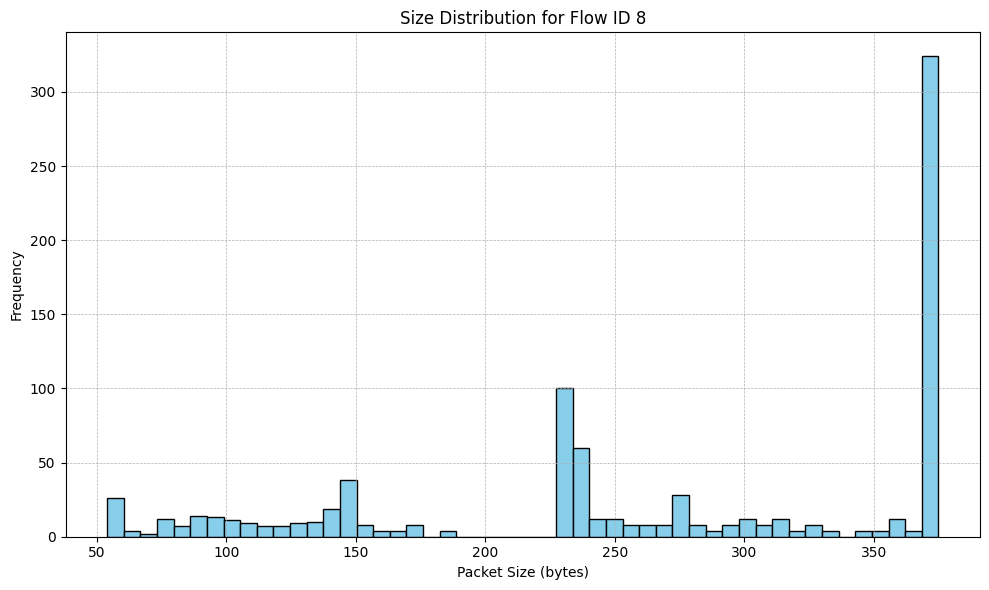

{'mean': 807.598615916955, 'min': 54, 'max': 1500, 'std': 578.8214055420335}

In [172]:
truncated_packets = adjust_packet_size(truncated_packets, flow_id=8, direction=0, method='uniform', scaling_factor=0.1, focus_point='low')
plot_size_distribution(truncated_packets, 8)
calculate_size_statistics(8, truncated_packets, direction=0)

In [173]:
# Przykład użycia
fragmentation_counts = count_fragmentation_types(truncated_packets, 8)
print("Fragmentation counts:", fragmentation_counts)

Fragmentation counts: {0: 72, 1: 36, 2: 181}


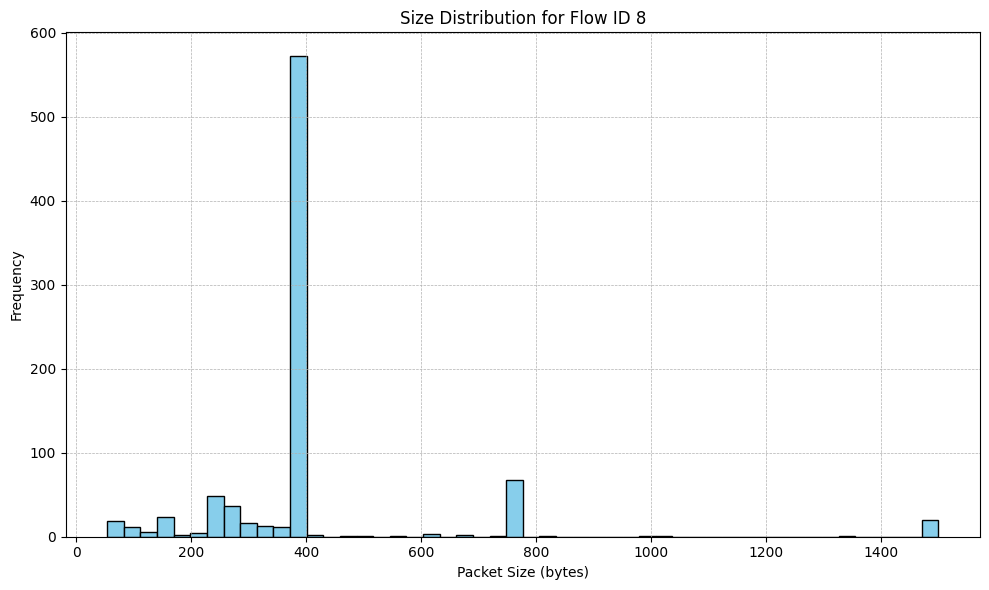

{'mean': 1207.1487889273355, 'min': 54, 'max': 1500, 'std': 501.87369550072805}

In [175]:
adjust_packet_size(truncated_packets, flow_id=8, direction=0, method='normal', scaling_factor=500.5, focus_point='middle')
plot_size_distribution(truncated_packets, 8)
calculate_size_statistics(8, truncated_packets, direction=0)

In [125]:
def count_fragmentation_types(truncated_packets, flow_id):
    """
    Counts how many packets are of each fragmentation type for a specified flow_id in a list of TruncatedPacket objects.
    
    Parameters:
    - truncated_packets: A list of TruncatedPacket objects.
    - flow_id: The specific flow_id for which to count fragmentation types.
    
    Returns:
    A dictionary with keys as the fragmentation types (0, 1, 2) and values as the count of packets for each type within the specified flow.
    """
    fragmentation_counts = {0: 0, 1: 0, 2: 0}
    
    for packet in truncated_packets:
        if packet.flow_id == flow_id and packet.fragmented in fragmentation_counts:
            fragmentation_counts[packet.fragmented] += 1
        elif packet.flow_id == flow_id:
            print(f"Unexpected fragmentation type found: {packet.fragmented}")
    
    return fragmentation_counts


## total perturbations

In [ ]:
# uzupelnienie flagami
# uzupelnienie iloscia pakietow w jakims ograniczonym zakresie (?)



## testing deltas

In [156]:
truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
truncated_packets = assign_flow_ids_to_packets(truncated_packets)
truncated_packets

[TruncatedPacket(packet_id=1, timestamp=1595284457.571949, size=66, pseudo_hash='-3608389843927323410', flow_id=1, direction='1', src_ip=192.168.56.1, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=0, psh=0, urg=0),
 TruncatedPacket(packet_id=2, timestamp=1595284457.57213, size=66, pseudo_hash='-3608389843927323410', flow_id=1, direction='2', src_ip=192.168.56.101, fragmented=0, tcp=1, udp=0, fin=0, syn=1, rst=0, ack=1, psh=0, urg=0),
 TruncatedPacket(packet_id=3, timestamp=1595284457.572317, size=60, pseudo_hash='-3608389843927323410', flow_id=1, direction='1', src_ip=192.168.56.1, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=0, urg=0),
 TruncatedPacket(packet_id=4, timestamp=1595284457.573703, size=98, pseudo_hash='-3608389843927323410', flow_id=1, direction='1', src_ip=192.168.56.1, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=1, urg=0),
 TruncatedPacket(packet_id=5, timestamp=1595284457.62409, size=54, pseudo_hash='-3608389843927323410', flow_id=

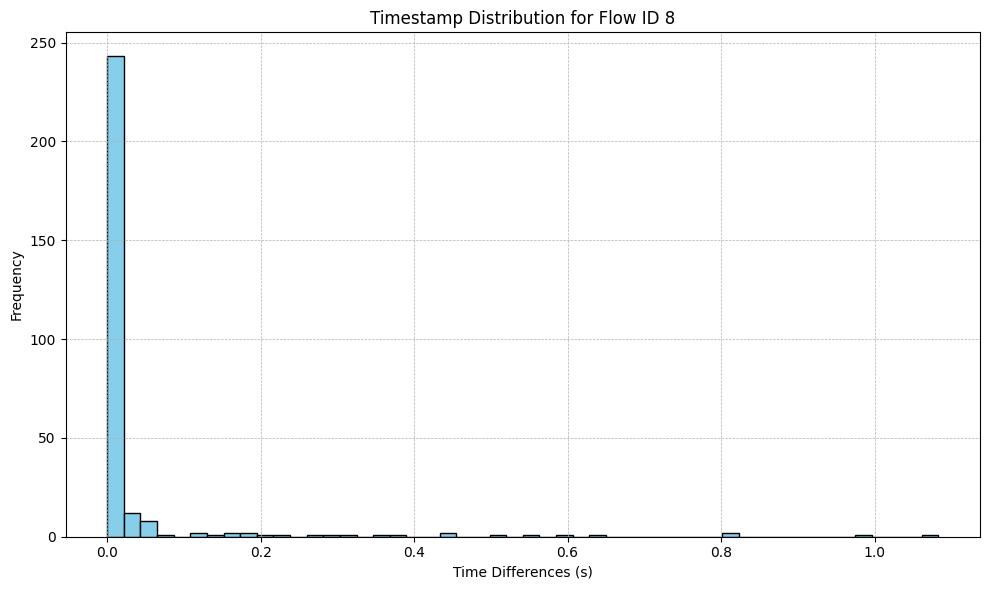

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_timestamp_distribution(truncated_packets, flow_id):
    """
    Plots the distribution of timestamps for a specified flow_id from a list of TruncatedPacket objects.
    
    Parameters:
    - truncated_packets: A list of TruncatedPacket objects.
    - flow_id: The specific flow_id for which the timestamp distribution is to be plotted.
    """
    
    # Extract timestamps for the specified flow_id
    timestamps = [packet.timestamp for packet in truncated_packets if packet.flow_id == flow_id]
    
    # Check if there are any timestamps to plot
    if not timestamps:
        print(f"No timestamps found for flow_id {flow_id}.")
        return
    
    # Convert timestamps to a numpy array
    timestamps = np.array(timestamps)
    
    # Calculate differences between consecutive timestamps
    time_differences = np.diff(timestamps)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(time_differences, bins=50, color='skyblue', edgecolor='black')
    
    plt.title(f'Timestamp Distribution for Flow ID {flow_id}')
    plt.xlabel('Time Differences (s)')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.show()

# Example usage
# truncated_packets = [TruncatedPacket(1, 1595284457.571949, 66, '-331772846983708113', 8, '192.168.56.1', '1'), 
#                      TruncatedPacket(2, 1595284457.57213, 66, '-331772846983708113', 8, '192.168.56.101', '2')]
plot_timestamp_distribution(truncated_packets, 8)


In [9]:
calculate_delta_time_statistics(8, truncated_packets, direction=0)

{'mean': 0.04010361805555556,
 'min': 2e-06,
 'max': 1.083255,
 'std': 0.13895261767263092}

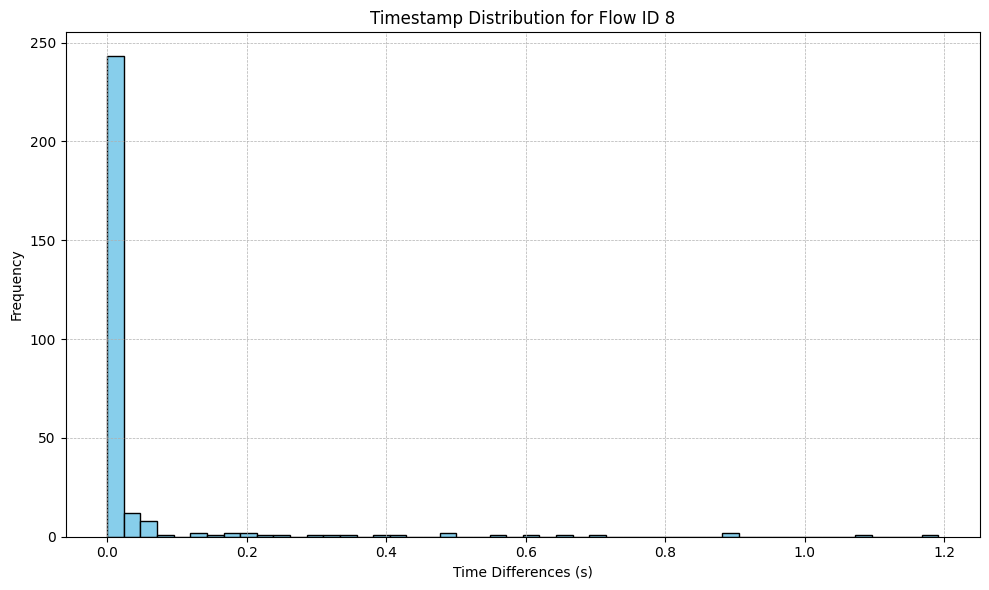

{'mean': 0.04411397986111112,
 'min': 2.2e-06,
 'max': 1.1915805000000002,
 'std': 0.152847879439894}

In [10]:
# Przykład użycia dla metody 'uniform'
truncated_packets = apply_perturbation(truncated_packets, flow_id=8, method='uniform', scaling_factor=1.1)
plot_timestamp_distribution(truncated_packets, 8)
calculate_delta_time_statistics(8, truncated_packets)


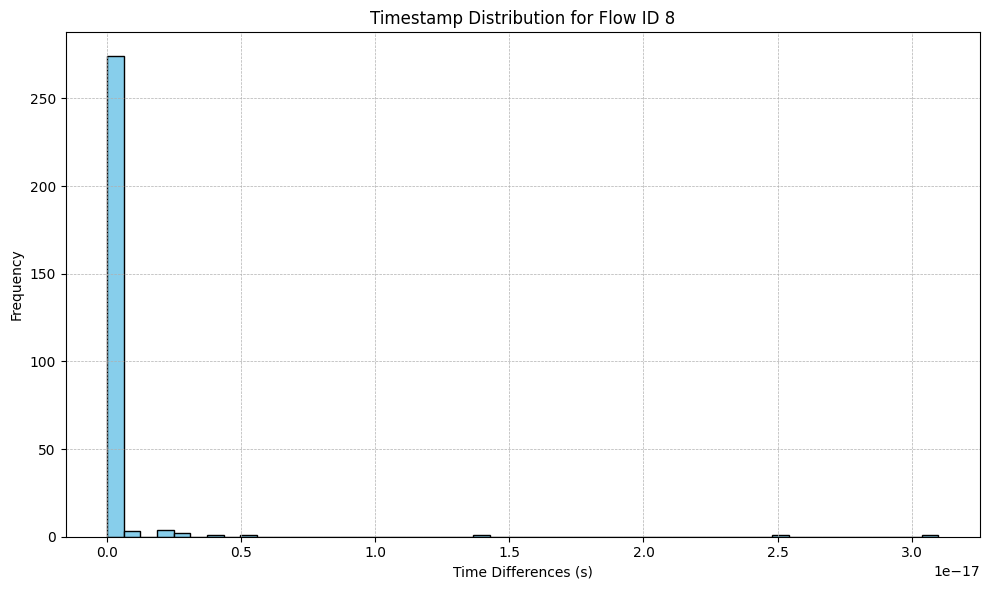

{'mean': 3.3333333333333334e-19,
 'min': 0.0,
 'max': 3.1e-17,
 'std': 2.5193694096384952e-18}

In [13]:
# Zastosowanie perturbacji typu 'normal' ze skupieniem na środku
truncated_packets = apply_perturbation_with_focus(truncated_packets, flow_id=8, method='normal', focus_point='end', scaling_factor=2.0)
plot_timestamp_distribution(truncated_packets, 8)
calculate_delta_time_statistics(8, truncated_packets)

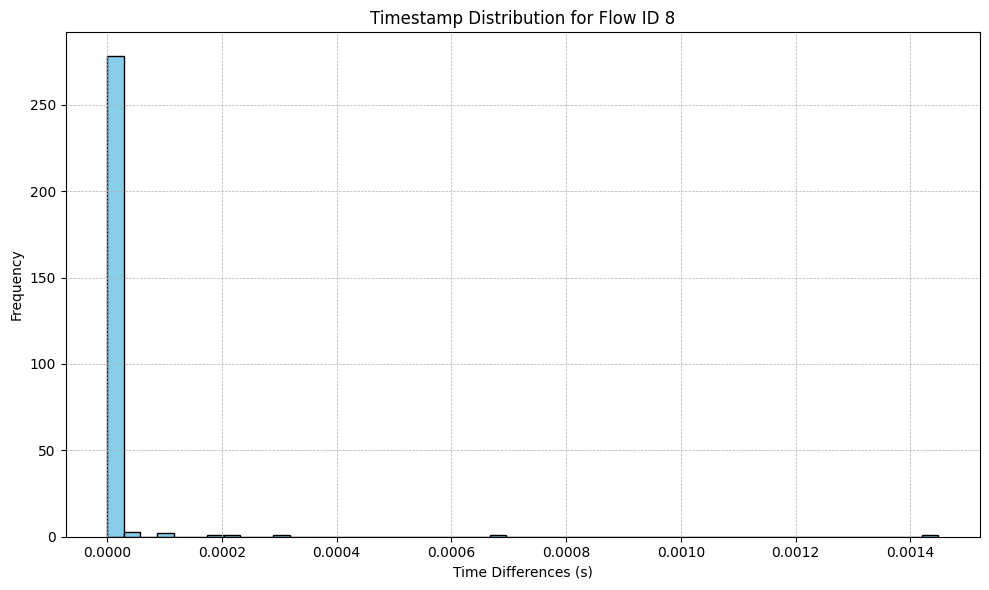

{'mean': 1.1521373535895336e-05,
 'min': 0.0,
 'max': 0.001448964707133875,
 'std': 9.683147799670752e-05}

In [12]:
# Zastosowanie perturbacji typu 'normal' ze skupieniem na początku
truncated_packets = apply_perturbation_with_focus(truncated_packets, flow_id=8, method='normal', focus_point='start', scaling_factor=2.0)
plot_timestamp_distribution(truncated_packets, 8)
calculate_delta_time_statistics(8, truncated_packets)

## testing size